In [25]:
import pandas as pd
import numpy as np
delhi = pd.read_csv("delhi-restaurants.csv")
bangalore = pd.read_csv("bangalore-restaurants.csv")
goa = pd.read_csv("goa-restaurants.csv")

In [26]:
states=["delhi","bangalore","goa"]
delhi.insert(1,'state',states[0],allow_duplicates=True)
bangalore.insert(1,'state',states[1],allow_duplicates=True)
goa.insert(1,'state',states[2],allow_duplicates=True)

#Concatenate all states into one dataframe-
total = pd.concat([delhi,bangalore,goa], ignore_index=True)
total = total[total.rating != '-']
total['rating'] = total['rating'].apply(pd.to_numeric)

In [3]:
from datetime import *
import dateutil.parser as dparser
from sklearn import preprocessing
def time_it(t):
    #function to handle timings available in form of fuzzy strings
    if ("Noon" in t):
        t="12 PM"
    elif ("Midnight" in t):
        t="12 AM"
    try:
        t=int(dparser.parse(t,fuzzy=True).strftime('%H'))
    except:
        t=0
    return t

def preprocess(data):
    #rename columns to get rid of symbols and spaces
    data=data.rename(columns = {'cost for 2':'cost'})
    data=data.rename(columns = {'review-count':'reviews'})
    data.fillna(0,axis=0,inplace=True)
    #convert dummy variables
    data=pd.concat([data, data['cuisines'].str.get_dummies(sep=', ')], axis=1)
    #remove ruppee symbol
    data['cost'] = data['cost'].str.replace(',','')
    data['cost'] = data['cost'].str.replace('-','')
    data['reviews'] = data['reviews'].str.replace(',','')
    data['reviews'] = data['reviews'].str.replace('-','')
    data['cost'] = data['cost'].map(lambda x: int(str(x)[3:]))
    data['reviews'] = data['reviews'].map(lambda x: int(str(x)[:-7]))
    data.rating=data.rating.fillna("")
    for index,r in data.iterrows():
            o=time_it(r.timings[:8])
            data.set_value(index,'opening',o)
            c=time_it(r.timings[-8:])
            data.set_value(index,'closing',c)
    return data

In [4]:
%%time
total=preprocess(total)

CPU times: user 10.1 s, sys: 388 ms, total: 10.5 s
Wall time: 10.5 s


In [5]:
le = preprocessing.LabelEncoder()
le.fit(total.state)
total.state=le.transform(total.state)

In [6]:
#define features to be used and target to be predicted
features=total.columns.difference(['cuisines','timings','rating','name'])
target='rating'

In [7]:
from sklearn import cross_validation
# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test = cross_validation.train_test_split(total, test_size=0.2)
# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 11548 samples.
Testing set has 2887 samples.


In [8]:
from sklearn.metrics import mean_squared_error
from time import time
def train_regressor(rgr, X_train, y_train):
    ''' Fits a regressor to the training data. '''
    # Start the clock, train the regressor, then stop the clock
    start = time()
    rgr.fit(X_train, y_train)
    end = time()
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)


def predict_labels(rgr, features, target):
    ''' Makes predictions using a fit regressor based on mean_squared_error '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = rgr.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    #return mean_squared_error(target.values, y_pred)
    return np.sqrt(((y_pred - target.values) ** 2).mean())



def train_predict(rgr, X_train, y_train, X_test, y_test):
    ''' Train and predict using a regressor based on error. '''
    
    # Indicate the regressor and the training set size
    print "Training a {} using a training set size of {}. . .".format(rgr.__class__.__name__, len(X_train))
    
    # Train the regressor
    train_regressor(rgr, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "mean_squared_error for training set: {:.4f}.".format(predict_labels(rgr, X_train, y_train))
    print "mean_squared_error for test set: {:.4f}.".format(predict_labels(rgr, X_test, y_test))

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
rgr_A = DecisionTreeRegressor(random_state=0)
rgr_B = KNeighborsRegressor()
rgr_C = GradientBoostingRegressor()

In [10]:
train_predict(rgr_A, X_train[features], X_train[target], X_test[features], X_test[target])

Training a DecisionTreeRegressor using a training set size of 11548. . .
Trained model in 0.1832 seconds
Made predictions in 0.0095 seconds.
mean_squared_error for training set: 0.0248.
Made predictions in 0.0027 seconds.
mean_squared_error for test set: 0.4926.


In [11]:
train_predict(rgr_B, X_train[features], X_train[target], X_test[features], X_test[target])

Training a KNeighborsRegressor using a training set size of 11548. . .
Trained model in 0.1779 seconds
Made predictions in 1.3312 seconds.
mean_squared_error for training set: 0.3153.
Made predictions in 0.3328 seconds.
mean_squared_error for test set: 0.3665.


In [12]:
train_predict(rgr_C, X_train[features], X_train[target], X_test[features], X_test[target])

Training a GradientBoostingRegressor using a training set size of 11548. . .
Trained model in 2.9691 seconds
Made predictions in 0.0353 seconds.
mean_squared_error for training set: 0.3425.
Made predictions in 0.0082 seconds.
mean_squared_error for test set: 0.3276.


In [13]:
feat={}
for i,j in zip(features,rgr_C.feature_importances_):
    feat[i]=j

In [14]:
v={}
for x in ['opening','closing','cost','reviews','state']:
    v[x]=feat[x]
v['cuisine']=1-sum(v.values())
df=pd.DataFrame(v.items(), columns=['name', 'value'])

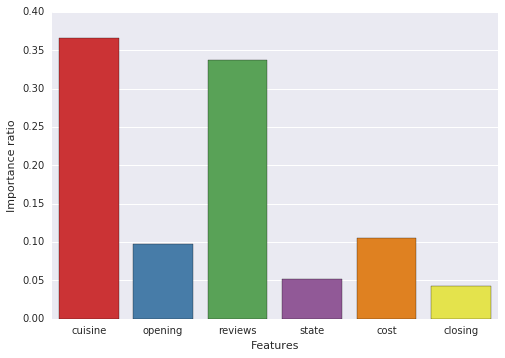

In [15]:
#from bokeh.plotting import figure, output_file, show,  output_notebook
#from bokeh.charts import Bar
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
ax=sns.barplot(x="name", y="value",data=df, palette="Set1")
ax.figsize=(40,40)
ax.set(xlabel='Features', ylabel='Importance ratio')

In [29]:
goa= goa[goa.rating != '-']
delhi= delhi[delhi.rating != '-']
bangalore= bangalore[bangalore.rating != '-']

goa=preprocess(goa)
delhi=preprocess(delhi)
bangalore=preprocess(bangalore)

In [ ]:
#d1=pd.DataFrame(feat.items(), columns=['name', 'value'])

In [71]:
cuisines_d=delhi.columns.difference(['cuisines','timings','name','opening','closing','cost','reviews','state'])
cuisines_g=goa.columns.difference(['cuisines','timings','name','opening','closing','cost','reviews','state'])
cuisines_b=bangalore.columns.difference(['cuisines','timings','name','opening','closing','cost','reviews','state'])
all_cuisines=features.difference(['cuisines','timings','name','opening','closing','cost','reviews','state','rating'])
d={}
g={}
b={}

In [88]:
def state_insights(s):
    d={}
    sd=s.sort_values('rating', axis=0,ascending=False)
    d['timing']=str("Most retaraunts open between- " +str(int(sd.describe().iloc[1][-2:-1]))+"AM to "+str(int(sd.describe().iloc[1][-1])-12)+"PM")
    d['cost']="Average cost of restaraunts- Rs."+str(int(sd.describe().iloc[1][1]))
    d['best']="Best Restaraunt ="+str(sd.iloc[0][0])
    x=str(d['timing']+", "+ d['cost']+", "+d['best'])
    return d

In [114]:
p=state_insights(goa)
q=state_insights(bangalore)
r=state_insights(delhi)
x=all_cuisines.difference(cuisines_g)
y=all_cuisines.difference(cuisines_b)
r=str(r)+", Unique cuisines of state-"+str(set(y).intersection(x))[5:-3]
y=all_cuisines.difference(cuisines_d)
q=str(q)+", Unique cuisines of state-"+str(set(y).intersection(x))[5:-3]
x=all_cuisines.difference(cuisines_b)
p=str(p)+", Unique cuisines of state-"+str(set(y).intersection(x))[5:-3]

In [117]:
import folium
folium.initialize_notebook()
map_2 = folium.Map(location=[20.8913, 78.0792],tiles='Stamen Toner',zoom_start=4)
folium.CircleMarker(location=[15.2993, 74.1240], radius=50000,popup=str(p), color='#3186cc',fill_color='#3186cc').add_to(map_2)
folium.CircleMarker(location=[12.971, 77.594], radius=50000,popup=str(q), color='#3186cc',fill_color='#3186cc').add_to(map_2)
folium.CircleMarker(location=[28.704, 77.102], radius=50000,popup=str(r), color='#3186cc',fill_color='#3186cc').add_to(map_2)
map_2

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: initialize_notebook is deprecated and no longer required.
  from ipykernel import kernelapp as app
